In [1]:
import os
import pandas as pd

# Define dataset paths
data_path = r"C:\Users\HP\Desktop\NASA_BATTERY_dataset\cleaned_dataset\data"
metadata_path = r"C:\Users\HP\Desktop\NASA_BATTERY_dataset\cleaned_dataset\metadata.csv"

# Function to inspect a CSV file
def inspect_csv_file(file_path, file_name):
    print(f"\nInspecting file: {file_name}")
    try:
        # Load CSV file
        df = pd.read_csv(file_path)
        # Display column names
        print("  Columns in the file:")
        for col in df.columns:
            print(f"    - {col}")
        # Display first 5 rows
        print("\n  First 5 rows of data:")
        print(df.head())
        # Display basic info (e.g., data types, non-null counts)
        print("\n  DataFrame Info:")
        df.info()
        return df
    except Exception as e:
        print(f"  Error loading {file_name}: {str(e)}")
        return None

# Inspect metadata.csv
if os.path.exists(metadata_path):
    inspect_csv_file(metadata_path, "metadata.csv")
else:
    print(f"\nError: {metadata_path} not found.")

# Inspect a sample CSV file from the data directory (e.g., 00001.csv)
sample_csv = os.path.join(data_path, "00001.csv")
if os.path.exists(sample_csv):
    inspect_csv_file(sample_csv, "00001.csv")
else:
    print(f"\nError: {sample_csv} not found.")

# List the first few CSV files in the data directory to confirm
print(f"\nListing first 10 files in: {data_path}")
try:
    files = os.listdir(data_path)[:10]  # Limit to first 10 for brevity
    for file in files:
        print(f"  - {file}")
except Exception as e:
    print(f"  Error listing files: {str(e)}")

print("\nExploration complete. Review the columns to identify fields for EIS, voltage, capacity, and cycle count.")


Inspecting file: metadata.csv
  Columns in the file:
    - type
    - start_time
    - ambient_temperature
    - battery_id
    - test_id
    - uid
    - filename
    - Capacity
    - Re
    - Rct

  First 5 rows of data:
        type                                         start_time  \
0  discharge  [2010.       7.      21.      15.       0.    ...   
1  impedance  [2010.       7.      21.      16.      53.    ...   
2     charge  [2010.       7.      21.      17.      25.    ...   
3  impedance                    [2010    7   21   20   31    5]   
4  discharge  [2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...   

   ambient_temperature battery_id  test_id  uid   filename  \
0                    4      B0047        0    1  00001.csv   
1                   24      B0047        1    2  00002.csv   
2                    4      B0047        2    3  00003.csv   
3                   24      B0047        3    4  00004.csv   
4                    4      B0047        4    5  00005.csv   

 

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set professional plotting style
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Define dataset paths
meta_file = r"C:\Users\HP\Desktop\NASA_BATTERY_dataset\cleaned_dataset\metadata.csv"

# Load metadata
try:
    metadata = pd.read_csv(meta_file)
    print("Successfully loaded metadata.")
except Exception as e:
    print(f"Failed to load metadata: {str(e)}")
    exit()

# Function to process EIS data for a given battery
def process_eis_data(battery_id):
    # Filter for battery, 24°C, impedance tests
    eis_data = metadata[
        (metadata['battery_id'] == battery_id) &
        (metadata['ambient_temperature'] == 24) &
        (metadata['type'] == 'impedance')
    ]
    
    if eis_data.empty:
        print(f"No impedance data found for Battery {battery_id} at 24°C.")
        return None
    
    print(f"Found {len(eis_data)} impedance records for Battery {battery_id}.")
    
    # Extract EIS data
    real_impedance = eis_data['Re'].astype(float)  # Real impedance (kΩ)
    imag_impedance = [0] * len(real_impedance)     # Placeholder for imaginary impedance
    cycle_count = eis_data['uid'].astype(int)      # UID as cycle count proxy
    
    return real_impedance, imag_impedance, cycle_count

# Try Battery B0005 first
print("Attempting to process Battery B0005...")
result = process_eis_data('B0005')

# Fallback to Battery B0047 if no data
if result is None:
    print("No valid data for B0005. Trying Battery B0047...")
    result = process_eis_data('B0047')
    battery_id = 'B0047'
else:
    battery_id = 'B0005'

# Unpack results
if result is None:
    print("No valid EIS data generated for any battery. Check metadata.")
    exit()
real_impedance, imag_impedance, cycle_count = result

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    real_impedance,
    imag_impedance,
    cycle_count,
    c=cycle_count,
    cmap='viridis',
    s=60,
    alpha=0.8
)

# Set axis labels and title
ax.set_xlabel('Real Impedance, Re(Z) [kΩ]', labelpad=10)
ax.set_ylabel('Imaginary Impedance, -Im(Z) [kΩ]', labelpad=10)
ax.set_zlabel('Cycle Count', labelpad=10)
ax.set_title(f'3D EIS Plot: Impedance vs. Cycle Count\nBattery {battery_id}, 24°C', pad=15)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cycle Count', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Set axis limits
ax.set_xlim(min(real_impedance) * 0.95, max(real_impedance) * 1.05)
ax.set_ylim(-0.01, 0.01)  # Fixed range for placeholder
ax.set_zlim(min(cycle_count), max(cycle_count))

# Add note about missing imaginary impedance
ax.text2D(
    0.05, 0.02,
    'Note: Imaginary impedance (-Im(Z)) not available; set to zero.',
    transform=ax.transAxes,
    fontsize=8,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
)

# Save plot
plt.tight_layout()
plt.savefig('eis_3d_plot.png', dpi=300, bbox_inches='tight')
plt.savefig('eis_3d_plot.pdf', bbox_inches='tight')
plt.close()

print(f"3D EIS plot saved as 'eis_3d_plot.png' and '.pdf' for Battery {battery_id}")

Successfully loaded metadata.
Attempting to process Battery B0005...
Found 278 impedance records for Battery B0005.
3D EIS plot saved as 'eis_3d_plot.png' and '.pdf' for Battery B0005


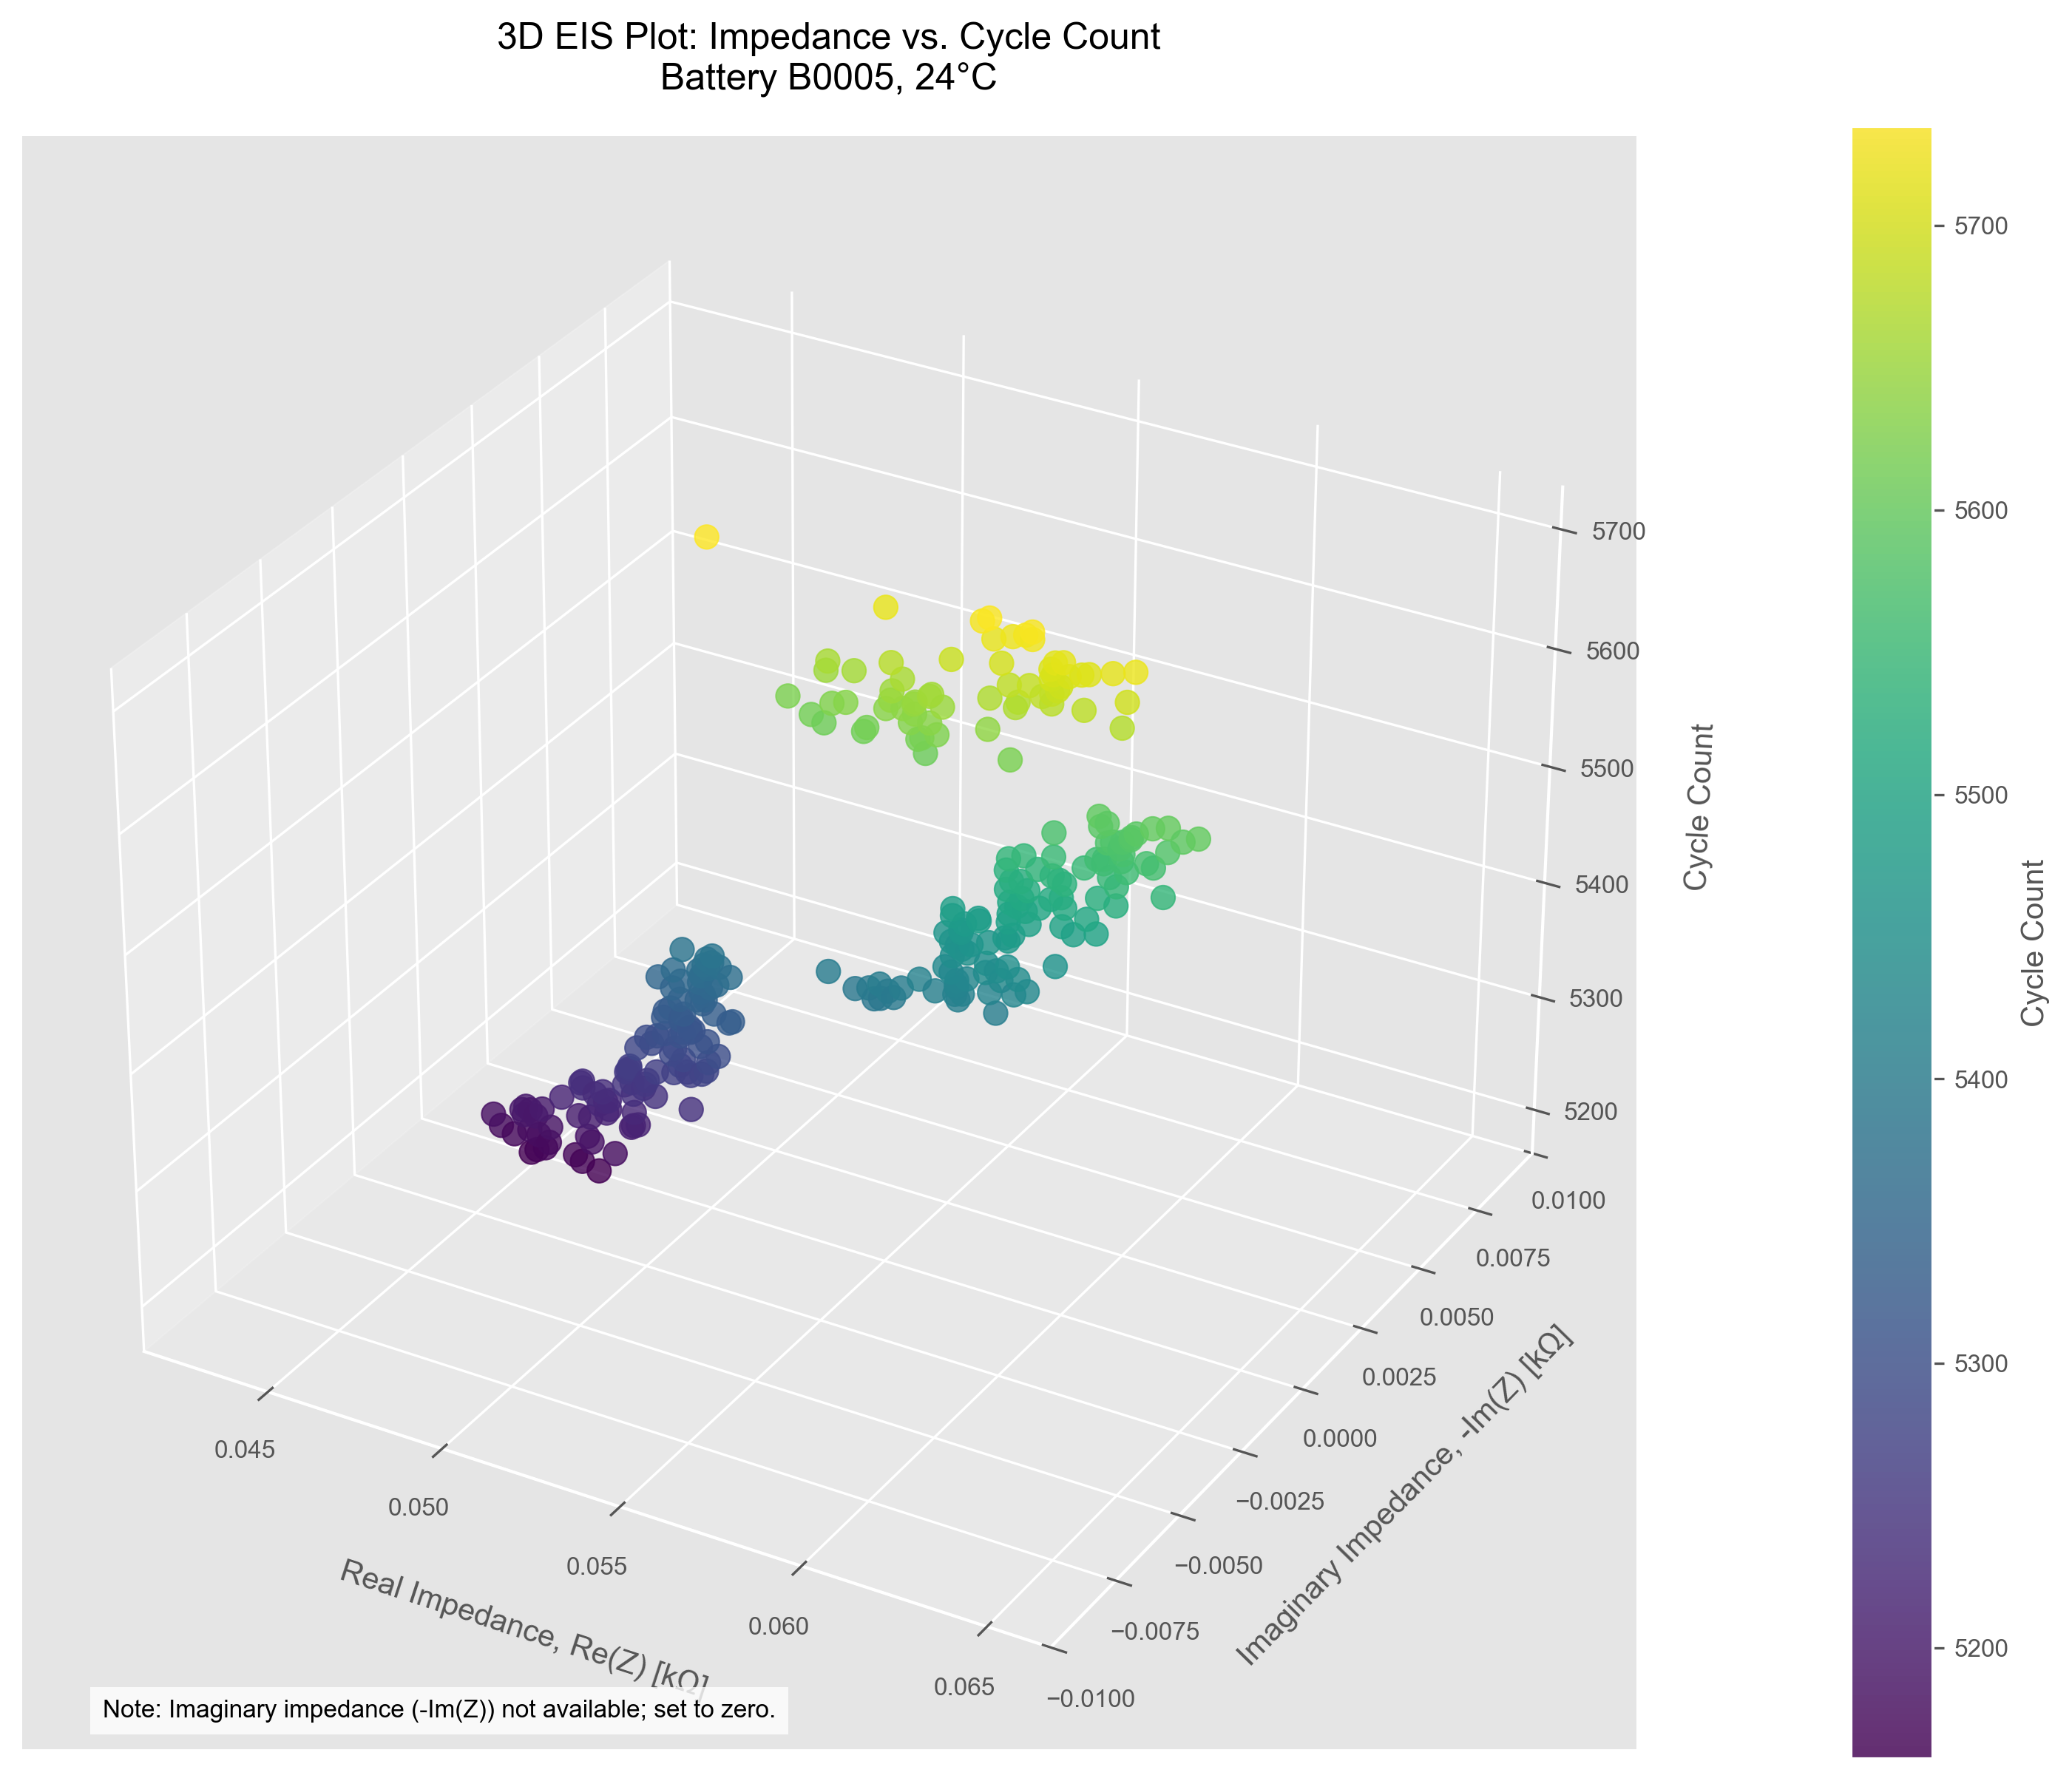

In [3]:

from IPython.display import Image
Image('eis_3d_plot.png')

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# Set professional plotting style
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Define dataset paths
data_dir = r"C:\Users\HP\Desktop\NASA_BATTERY_dataset\cleaned_dataset\data"
meta_file = r"C:\Users\HP\Desktop\NASA_BATTERY_dataset\cleaned_dataset\metadata.csv"

# Load metadata
try:
    meta_data = pd.read_csv(meta_file)
    print("Successfully loaded metadata.")
except Exception as e:
    print(f"Failed to load metadata: {str(e)}")
    exit()

# Function to process charge cycles for a given battery
def process_charge_cycles(battery_id):
    # Filter for battery and charge cycles
    charge_data = meta_data[
        (meta_data['battery_id'] == battery_id) &
        (meta_data['type'] == 'charge')
    ]
    
    if charge_data.empty:
        print(f"No charge cycle data found for Battery {battery_id}.")
        return None
    
    print(f"Found {len(charge_data)} charge cycle files for Battery {battery_id}.")
    
    # Initialize data lists
    voltages = []
    dq_dv_values = []
    cycles = []
    
    # Process each charge cycle file
    for _, row in charge_data.iterrows():
        file_name = row['filename']
        cycle_id = row['uid']
        file_path = os.path.join(data_dir, file_name)
        
        if not os.path.exists(file_path):
            print(f"File not found: {file_name}")
            continue
        
        try:
            df = pd.read_csv(file_path)
            # Extract time, voltage, current
            time = df['Time'].values
            voltage = df['Voltage_measured'].values
            current = df['Current_measured'].values
            
            if len(voltage) < 5 or len(current) < 5:
                print(f"Skipping {file_name}: Too few data points ({len(voltage)}).")
                continue
                
            # Compute capacity (Q = ∫I dt)
            delta_t = np.diff(time, prepend=time[0])
            capacity = np.cumsum(current * delta_t) / 3600  # Convert to Ah
            
            # Compute dQ/dV
            dq_dv = np.gradient(capacity, voltage)
            
            # Filter valid data
            valid = (np.isfinite(dq_dv)) & (np.abs(dq_dv) < 20) & (voltage > 2.0)
            if np.sum(valid) > 0:
                print(f"Processed {file_name}: {np.sum(valid)} valid data points.")
                voltages.extend(voltage[valid])
                dq_dv_values.extend(dq_dv[valid])
                cycles.extend([cycle_id] * np.sum(valid))
            else:
                print(f"No valid data points in {file_name} after filtering.")
                
        except Exception as e:
            print(f"Error processing {file_name}: {str(e)}")
    
    return voltages, dq_dv_values, cycles

# Try Battery B0005 first
print("Attempting to process Battery B0005...")
result = process_charge_cycles('B0005')

# Fallback to Battery B0047 if no data
if result is None or not result[0]:
    print("No valid data for B0005. Trying Battery B0047...")
    result = process_charge_cycles('B0047')
    battery_id = 'B0047'
else:
    battery_id = 'B0005'

# Unpack results
if result is None or not result[0]:
    print("No valid ICA data generated for any battery. Check data quality or file paths.")
    exit()
voltages, dq_dv_values, cycles = result

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    voltages,
    dq_dv_values,
    cycles,
    c=cycles,
    cmap='viridis',
    s=40,
    alpha=0.8
)

# Set axis labels and title
ax.set_xlabel('Voltage [V]', labelpad=10)
ax.set_ylabel('Incremental Capacity, dQ/dV [Ah/V]', labelpad=10)
ax.set_zlabel('Cycle Count', labelpad=10)
ax.set_title(f'3D ICA Plot: Incremental Capacity vs. Cycle Count\nBattery {battery_id}, 4°C', pad=15)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cycle Count', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Set axis limits
ax.set_xlim(2.0, max(voltages) * 1.05)
ax.set_ylim(0, max(dq_dv_values) * 1.1 if dq_dv_values else 10)
ax.set_zlim(min(cycles), max(cycles))

# Add note about temperature
ax.text2D(
    0.05, 0.02,
    'Note: Charge cycles at 4°C. dQ/dV peaks indicate electrochemical reactions.',
    transform=ax.transAxes,
    fontsize=8,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
)

# Save plot
plt.tight_layout()
plt.savefig('ica_3d_plot.png', dpi=300, bbox_inches='tight')
plt.savefig('ica_3d_plot.pdf', bbox_inches='tight')
plt.close()

print(f" 3D ICA plot saved as 'ica_3d_plot.png' and '.pdf' for Battery {battery_id}")

Successfully loaded metadata.
Attempting to process Battery B0005...
Found 170 charge cycle files for Battery B0005.
Processed 05121.csv: 662 valid data points.
Processed 05123.csv: 807 valid data points.
Processed 05125.csv: 809 valid data points.
Processed 05127.csv: 809 valid data points.
Processed 05129.csv: 800 valid data points.
Processed 05131.csv: 826 valid data points.
Processed 05133.csv: 833 valid data points.
Processed 05135.csv: 787 valid data points.
Processed 05137.csv: 797 valid data points.
Processed 05139.csv: 801 valid data points.
Processed 05141.csv: 785 valid data points.
Processed 05143.csv: 776 valid data points.
Processed 05144.csv: 760 valid data points.
Processed 05146.csv: 794 valid data points.
Processed 05148.csv: 824 valid data points.
Processed 05150.csv: 776 valid data points.
Processed 05152.csv: 800 valid data points.
Processed 05154.csv: 793 valid data points.
Processed 05156.csv: 772 valid data points.
Processed 05158.csv: 780 valid data points.
Pro

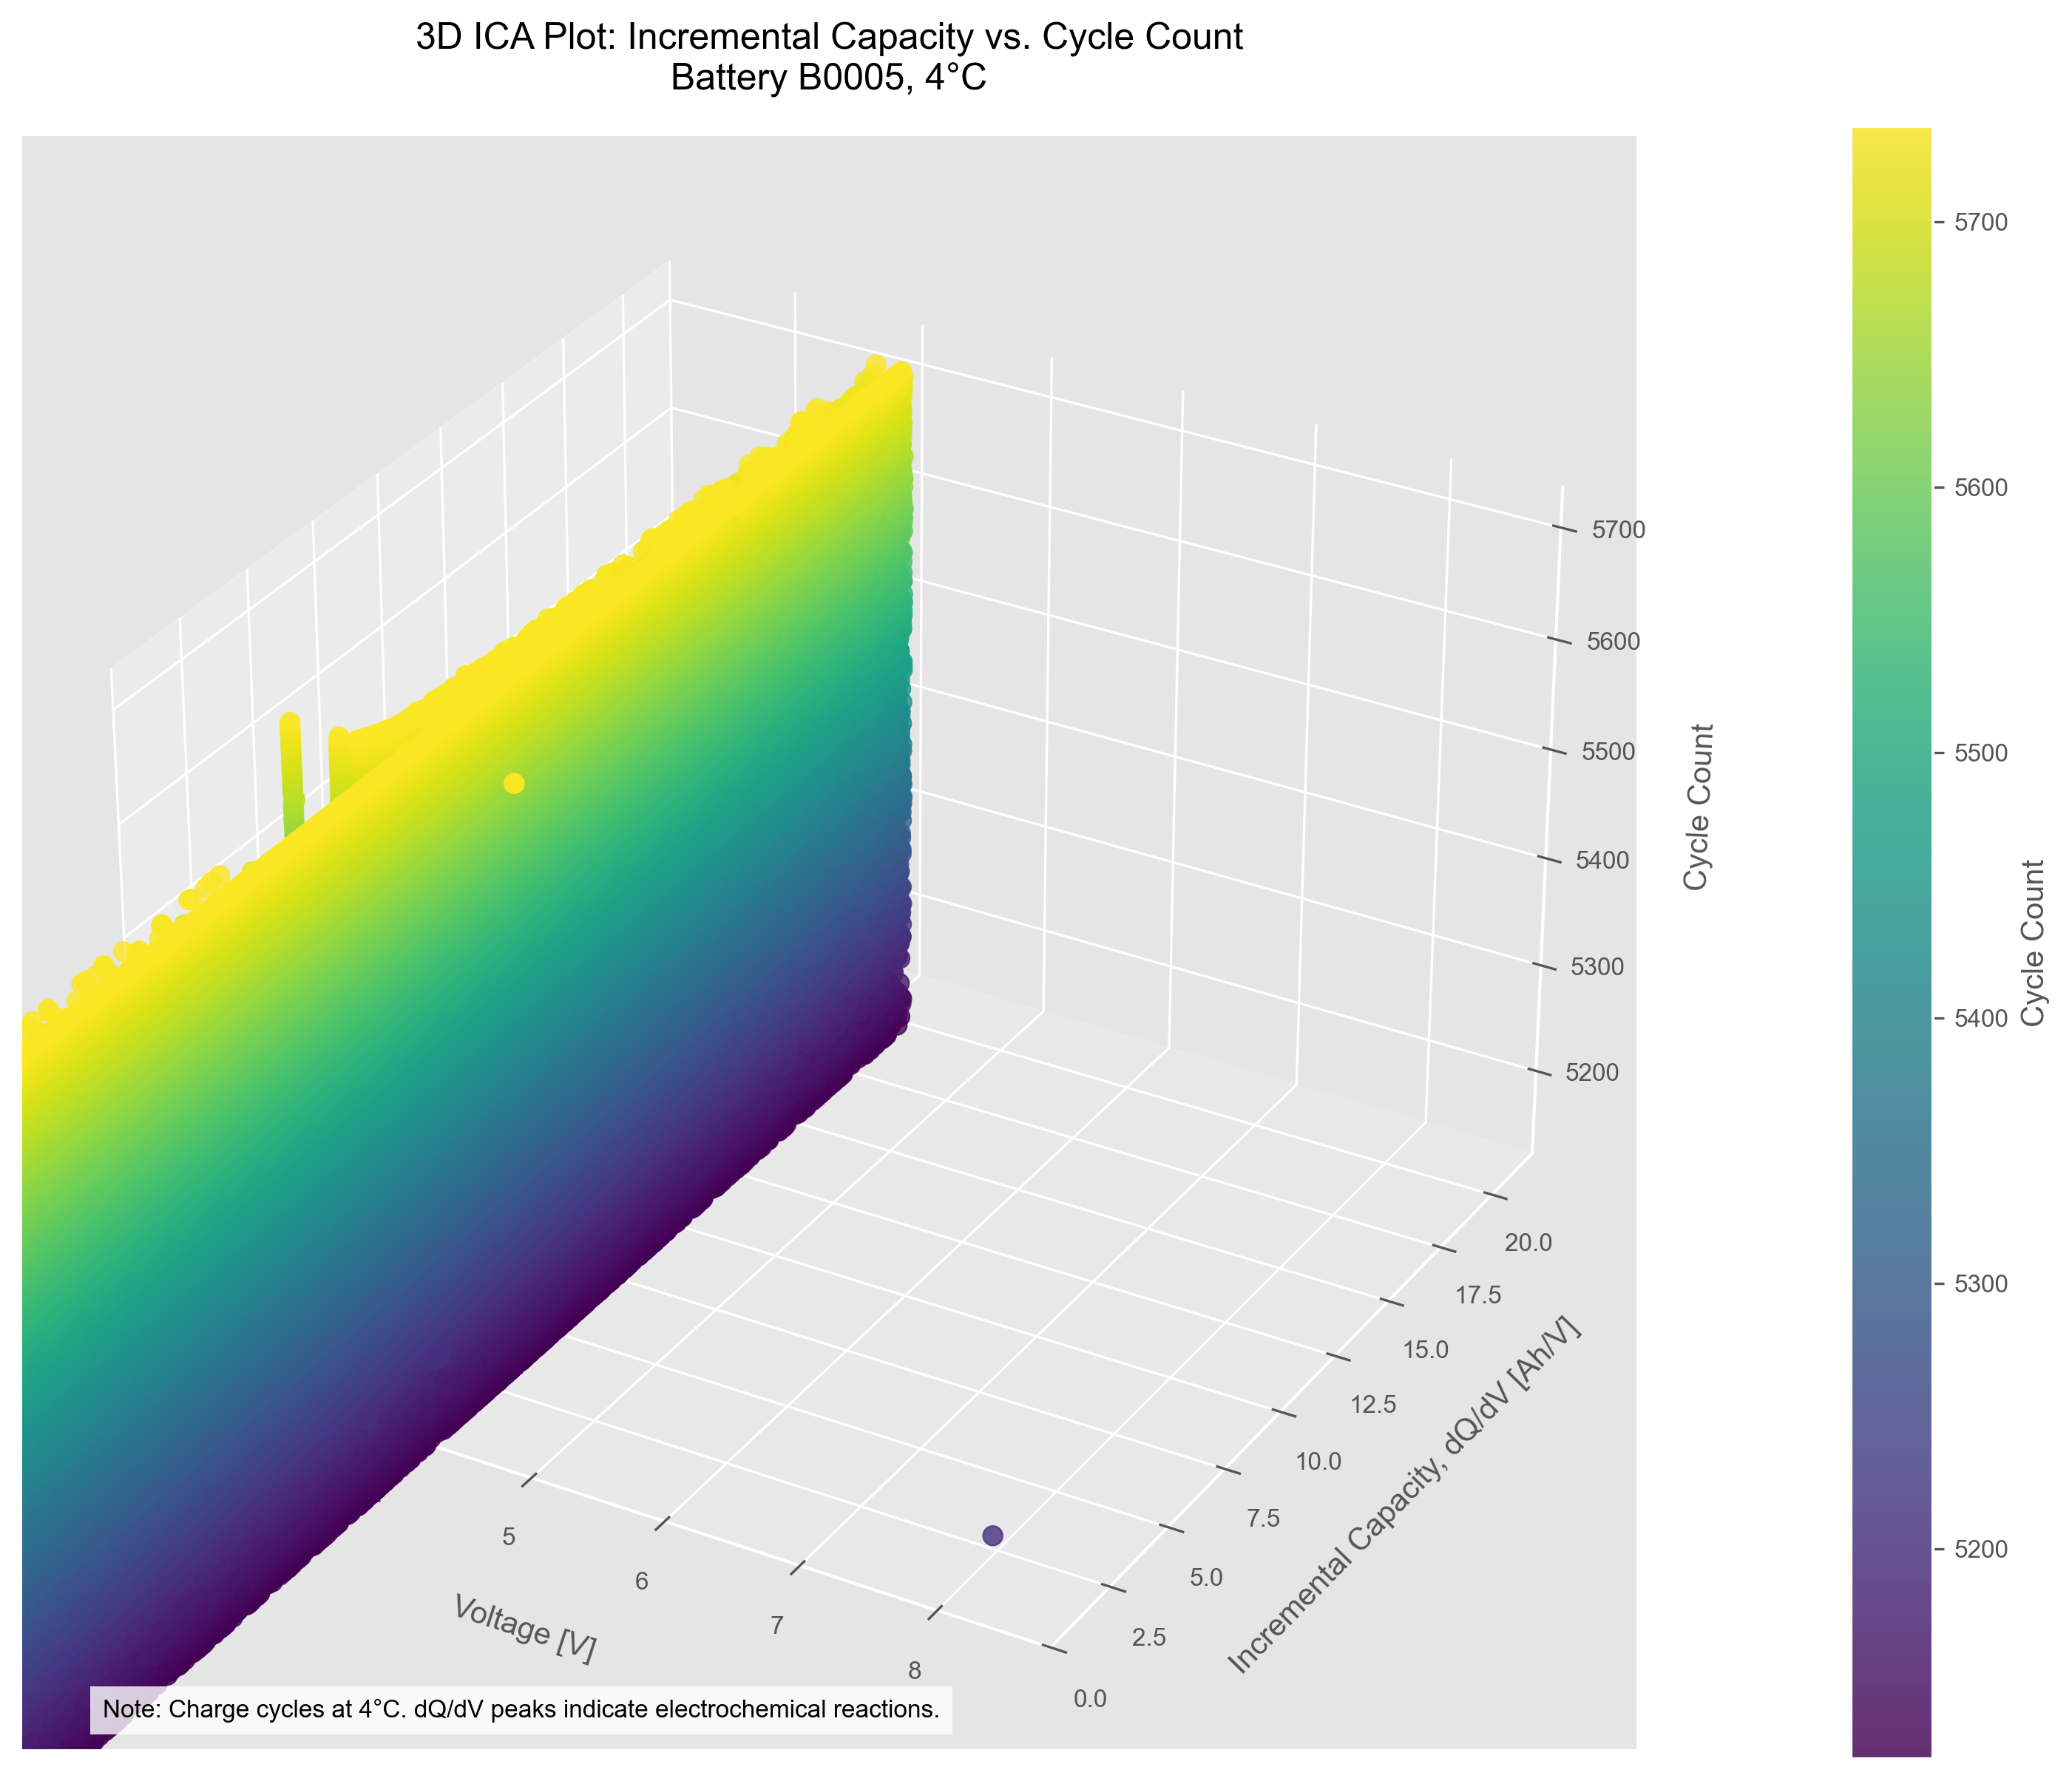

In [5]:
from IPython.display import Image
Image('ica_3d_plot.png')

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import joblib
import os

# Set plotting style
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

# Paths
meta_file = r"C:\Users\HP\Desktop\NASA_BATTERY_dataset\cleaned_dataset\metadata.csv"
data_dir = r"C:\Users\HP\Desktop\NASA_BATTERY_dataset\cleaned_dataset\data"

# Load metadata
try:
    metadata = pd.read_csv(meta_file, dtype={
        'battery_id': str, 'type': str, 'filename': str,
        'Re': str, 'Rct': str, 'Capacity': str, 'uid': 'Int64'
    })
    metadata['Capacity'] = pd.to_numeric(metadata['Capacity'].replace('[]', np.nan), errors='coerce')
    print("Loaded metadata.")
except Exception as e:
    print(f"Metadata error: {e}")
    raise ValueError("Cannot proceed.")

# Compute Capacity from .csv
def compute_capacity(file_path):
    try:
        df = pd.read_csv(file_path)
        if 'Time' not in df.columns or 'Current_measured' not in df.columns or len(df) < 5:
            print(f"Skipping {file_path}: Invalid data.")
            return None
        time = df['Time'].values
        current = df['Current_measured'].values
        delta_t = np.diff(time, prepend=time[0])
        capacity = np.cumsum(current * delta_t) / 3600  # Ah
        return capacity[-1]  # Return final capacity
    except Exception as e:
        print(f"Error in {file_path}: {e}")
        return None

# Load EIS data
def load_eis_data(metadata, data_dir, battery_id):
    eis_data = metadata[
        (metadata['battery_id'] == battery_id) &
        (metadata['type'] == 'impedance')
    ].copy()
    
    if eis_data.empty:
        print(f"No impedance data for {battery_id}.")
        return None, None
    
    print(f"Found {len(eis_data)} impedance records for {battery_id}.")
    
    eis_data['Re'] = pd.to_numeric(eis_data['Re'], errors='coerce')
    eis_data['Rct'] = pd.to_numeric(eis_data['Rct'], errors='coerce')
    
    # Get charge cycles
    charge_data = metadata[
        (metadata['battery_id'] == battery_id) &
        (metadata['type'] == 'charge')
    ]
    
    # Compute Capacity
    charge_capacity = {}
    for _, row in charge_data.iterrows():
        file_path = os.path.join(data_dir, row['filename'])
        if os.path.exists(file_path):
            capacity = compute_capacity(file_path)
            if capacity is not None and not np.isnan(capacity):
                charge_capacity[row['uid']] = capacity
    
    print(f"Computed Capacity for {len(charge_capacity)} charge cycles.")
    
    # Associate Capacity
    eis_data['Capacity'] = np.nan
    for idx, row in eis_data.iterrows():
        uid = row['uid']
        if pd.isna(uid):
            continue
        charge_uids = np.array([u for u in charge_capacity.keys() if not pd.isna(u)])
        if len(charge_uids) == 0:
            continue
        closest_uid = charge_uids[np.argmin(np.abs(charge_uids - uid))]
        eis_data.at[idx, 'Capacity'] = charge_capacity[closest_uid]
    
    eis_data = eis_data.dropna(subset=['Re', 'Rct', 'Capacity'])
    
    if eis_data.empty:
        print(f"No valid data for {battery_id}.")
        return None, None
    
    X = eis_data[['Re', 'Rct']].copy()
    X['Re_plus_Rct'] = X['Re'] + X['Rct']
    y = eis_data['Capacity'].astype(float)
    
    return X.values, y.values

# Try batteries
batteries = ['B0005', 'B0047', 'B0006']
X, y = None, None

for b_id in batteries:
    print(f"\nProcessing {b_id}...")
    X, y = load_eis_data(metadata, data_dir, b_id)
    if X is not None and len(X) >= 10:
        battery_id = b_id
        break

if X is None or len(X) < 10:
    print("No valid data. Check .csv files for Time and Current_measured.")
    raise ValueError("Cannot train model.")

print(f"Using {battery_id} with {len(X)} samples.")

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

# Plot
plt.figure(figsize=(6, 4), dpi=300)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Capacity [Ah]')
plt.ylabel('Predicted Capacity [Ah]')
plt.title(f'Gradient Boosting Predictions\nBattery {battery_id}')
plt.grid(True)
plt.tight_layout()
plt.savefig('predictions_plot.png', dpi=300)
plt.savefig('predictions_plot.pdf')
plt.close()

# Save model
joblib.dump(model, 'capacity_predictor.pkl')
joblib.dump(scaler, 'capacity_scaler.pkl')
print("Model saved.")

Loaded metadata.

Processing B0005...
Found 278 impedance records for B0005.
Computed Capacity for 170 charge cycles.
Using B0005 with 278 samples.
MAE: 0.0423
Model saved.


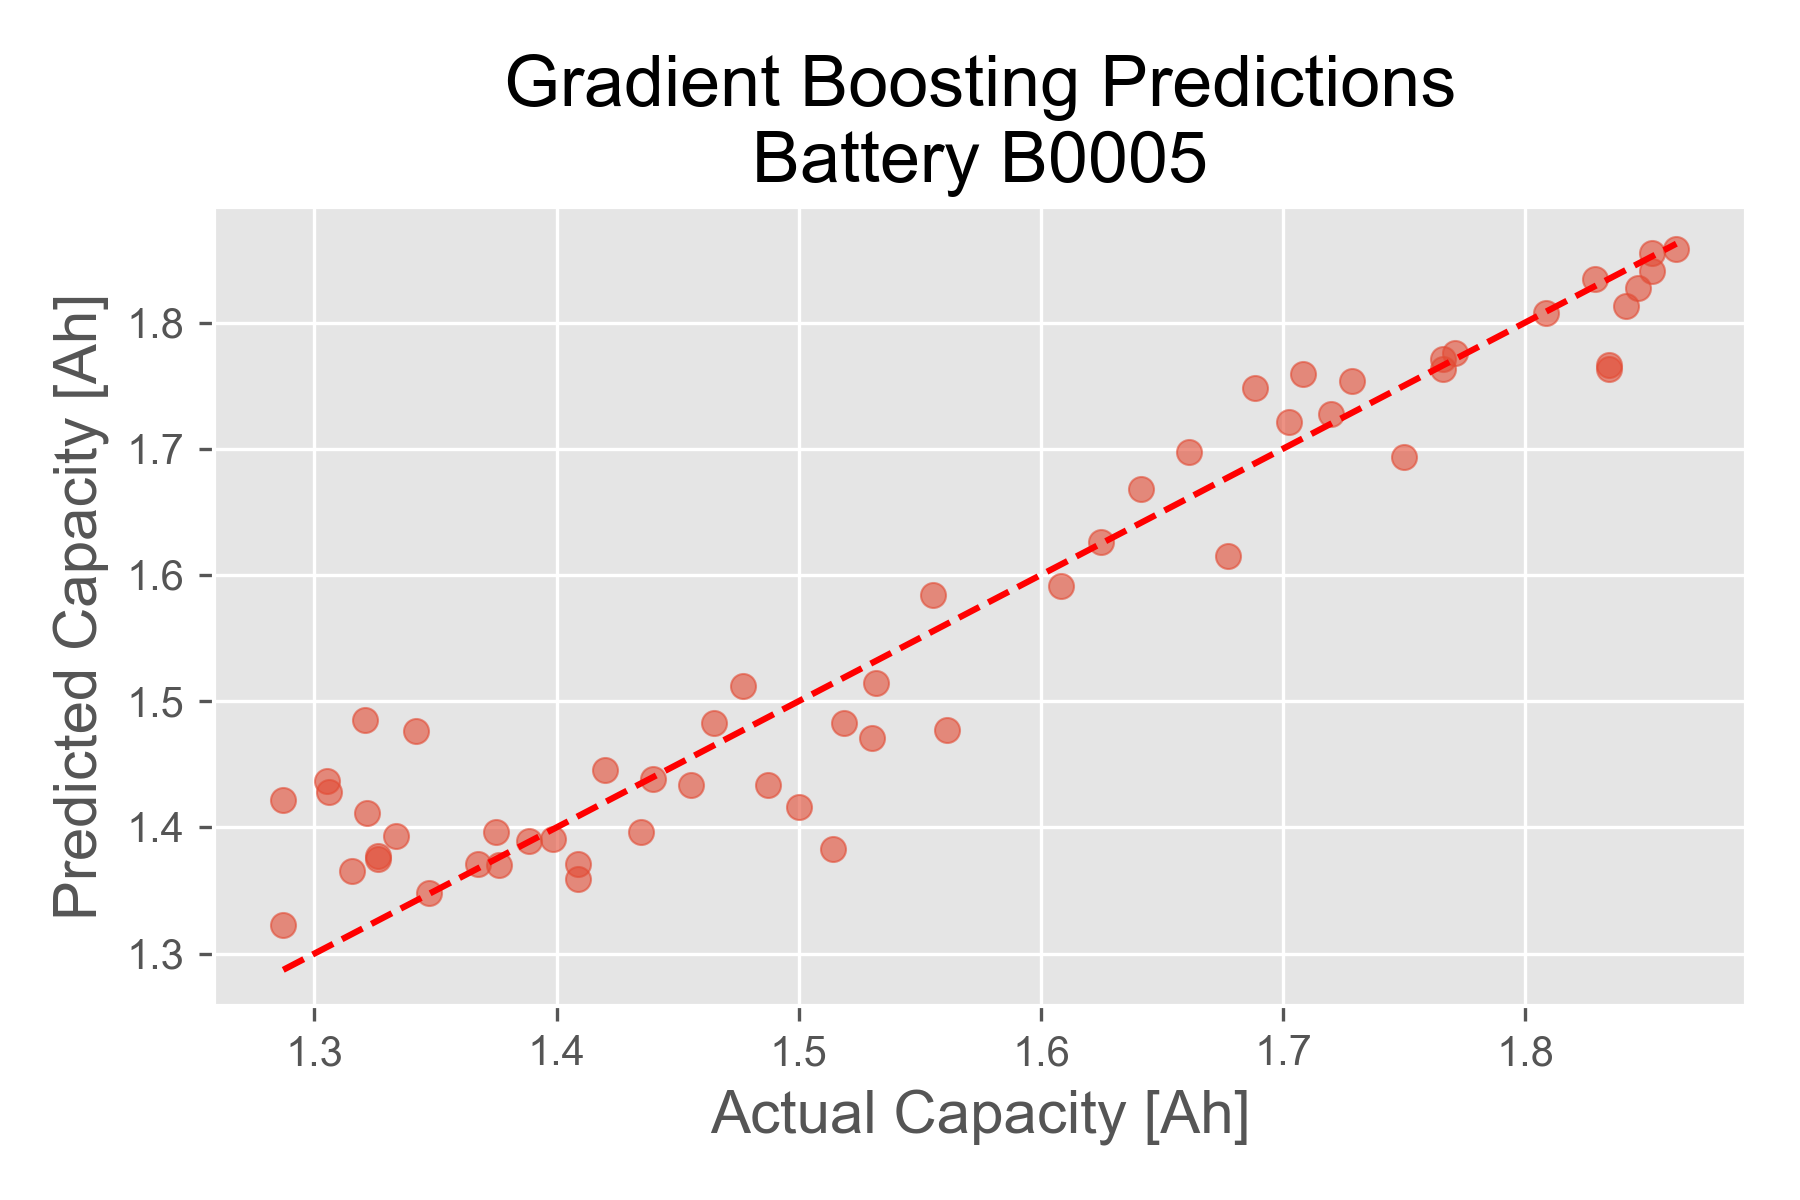

In [17]:
# Q3c: Predict battery capacity from EIS (Re, Rct) using Gradient Boosting.
from IPython.display import Image
Image('predictions_plot.png')